# README

## Project Overview

### Results
- Developed a machine learning model to predict next-month defaults for credit card users using credit card user data, achieving a prediction accuracy of 70.2%. Optimized model performance by fine-tuning LightGBM hyperparameters (using random search) to reduce overfitting and improve training and prediction speed.

### Project Objective
- Using the UCI credit card dataset, the goal was to develop a model to predict credit card default probabilities for the following month by analyzing a combination of customer data, including credit limits, age, payment patterns, and billing amounts, while identifying key predictive factors.

### Problem-Solving Approach
- Data Preprocessing and EDA
  - Removed unnecessary data such as IDs that are unrelated to customers' credit status.
  - Encoded categorical variables, such as gender and education level, using OneHotEncoder to make them suitable for analysis.
  - Analyzed the correlation of variables like PAY, BILL, and PAY_AMT to identify major factors influencing default probability.
  - Identified that PAY_0 (most recent delinquency status) has the most significant impact on default prediction.

### Modeling and Performance Evaluation
- Compared the performance of various models, including Dummy Classifier, Logistic Regression, Random Forest, SVC, and LightGBM.
- Selected LightGBM as the final model and optimized hyperparameters such as learning rate, n_estimators, and subsample using random search.
Improved model prediction accuracy to 70.2%.

### Feature Importance Analysis and Interpretation
- Used SHAP and eli5 to analyze the importance of key features. Key factors influencing the model's predictions were:
  - PAY_0 (recent delinquency rate),
  - LIMIT_BAL (credit limit),
  - PAY_AMT2 (second month's repayment amount).
- Discovered high correlations between PAY (delinquency information) and BILL_AMT (billing amounts), emphasizing their critical role in default prediction.

### Key Achievements
- **Achieved 70.2% Accuracy:** The optimized **LightGBM model** delivered the highest predictive performance, outperforming other models such as Dummy Classifier and Logistic Regression.
- **Identified Crucial Variables:** Verified through data analysis that variables such as **LIMIT_BAL** (credit limit) and **PAY_0** (recent delinquency status) play a pivotal role in predicting defaults, providing valuable insights for customer risk assessment.
- **Enhanced Data and Model Reliability:** Proposed methods to handle outliers and noise discovered during EDA and preprocessing, improving data reliability and model performance.

### Project Strengths
- **Persistence and Determination:** Repeatedly experimented with multiple models and fine-tuned hyperparameters to achieve the optimal outcome.
- **Problem Identification and Customer Insight:** Identified outliers in customer data and addressed factors negatively impacting model performance.
- **Quantifiable Results and Evidence-Based Reporting:** Presented project achievements with concrete prediction accuracy metrics and feature importance values.

### Future Improvement Plans
- Noise Handling: Refine “unknown” values in marriage and education status data and research methods to process incorrectly entered customer data, such as age.
- New Feature Engineering: Introduce features such as the difference between BILL_AMT and PAY_AMT to enhance the accuracy of default predictions.
- Model Comparison and Analysis: Explore additional machine learning models to improve prediction performance for the default class.








## 코드

In [ ]:
pip install xgboost matplotlib pandas numpy scikit-learn seaborn eli5 shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=d4585b3acd2205b8dbc21df5d27cef3f37952547680f0a2c63005248b2500988
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
from hashlib import sha1

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler



### Problem

#### My task is to predict whether a credit card client will default or not.
#### All features are numerically encoded. (some features such as sex and marriage seem categorical features)


# Data Splitting

### I split the data into train (70%) and test (30%) portions with random_state = 76

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/공부 & 학교/Project/CreditFault/data/UCI_Credit_Card.csv')

# df = pd.read_csv("data/UCI_Credit_Card.csv")
print(df)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=76)

# return tuples that has (# of rows, # of columns)
train_df.shape


          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

(21000, 25)

In [ ]:
# count how many different education we have
train_df['EDUCATION'].value_counts()

,count
EDUCATION,
2,9789
1,7522
3,3365
5,197
4,80
6,37
0,10


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

### My task
- Summary statistics
- visualizations
that can potentially be useful
- Summarize initial observations about the data
- Pick appropriate metric/metrics for assessment

#### The given table summarizes the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values.
- count: count # of elements in each feature
- mean: find the avg
- std: standard deviation
- min: minimum value of each feature
- 25%, 50%, 75%: 25th, 50th, 75th precentiles
- max: maximum value of each feature


In [ ]:
# summarize the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values.
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,15011.587619,167563.508571,1.604381,1.843905,1.554667,35.412952,-0.012190,-0.132714,-0.168333,-0.223143,...,43039.813952,40121.889810,38623.497095,5601.265286,6.059441e+03,5204.302571,4889.281333,4782.900857,5162.918714,0.221857
std,8658.232639,129919.112502,0.488995,0.789845,0.521970,9.136302,1.121864,1.196554,1.195375,1.165490,...,63817.414980,60400.798292,59055.005208,16239.423781,2.407470e+04,16865.645456,16486.840852,15431.523094,17170.608569,0.415505
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7493.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2300.000000,1800.000000,1266.250000,1000.000000,8.200000e+02,390.000000,291.000000,257.750000,150.000000,0.000000
50%,15041.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,18990.000000,18091.000000,17127.000000,2112.500000,2.009000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22505.750000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54740.000000,50065.250000,48950.500000,5012.000000,5.000000e+03,4531.250000,4048.500000,4078.000000,4001.000000,0.000000
max,29999.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


#### The given table provides informations about a DataFrame including the index dtype and columns, non-null values and memory usuage of features.


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 8958 to 2721
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                   21000 

- LIMIT_BAL: Credit limit (Users with a higher credit limit may have a lower likelihood of default).
- AGE: Age (Older individuals may have a lower likelihood of default).
- PAY_0 ~ PAY_6: Delinquency records over the past 6 months (The more delinquency records, the higher the likelihood of default).
- BILL_AMT1 ~ BILL_AMT6: Monthly billing amounts (Higher billing amounts with lower repayment amounts may increase the likelihood of default).
- PAY_AMT1 ~ PAY_AMT6: Monthly repayment amounts (Lower repayment amounts may increase the likelihood of default).

#### Below shows the corresponding fractions of binary feature "default.payment.next.month"

In [ ]:
train_df["default.payment.next.month"].value_counts(normalize=True)

,proportion
default.payment.next.month,
0,0.778143
1,0.221857


Confusion Matrix
- False Positive (FP)
    - The model spots incorrectly as fraud
    - non-fraud predicted as fraud
- False Negative (FN)
    - It is missing to spot fraud examples
    - fraud predicted as non-fraud
- True Postive (TP)
    - The model spots correctly as fraud
    - fraud predicted as fraud
- True Negative (TN)
    - num of examples that are actually non-fraud examples and also predicted as non-fraud examples
    - non-fraud predicted as non-fraud

F1 Score
- F1 score is machine learning evaluation metric that measures a model's accuracy.
- It combines the precision and recall scores of a model.
- could be used in hyperparameter optimization
- f1 = $2$  x $(precision * recall) \over (precision + recall)$

Precision
- How many were actually positive?
- presicion = $ TP \over (TP + FP) $

Recall
- How many did you identify?
- recall = $TP \over (TP + FN)$ = TP/(# of positives)



In [ ]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

# Show max values for each features
print(np.max(train_df, axis=0))

# Show  min values for each features
print(np.max(train_df, axis=0))

ID                              29999.0
LIMIT_BAL                      800000.0
SEX                                 2.0
EDUCATION                           6.0
MARRIAGE                            3.0
AGE                                79.0
PAY_0                               8.0
PAY_2                               8.0
PAY_3                               8.0
PAY_4                               8.0
PAY_5                               8.0
PAY_6                               8.0
BILL_AMT1                      746814.0
BILL_AMT2                      743970.0
BILL_AMT3                     1664089.0
BILL_AMT4                      706864.0
BILL_AMT5                      823540.0
BILL_AMT6                      568638.0
PAY_AMT1                       873552.0
PAY_AMT2                      1684259.0
PAY_AMT3                       889043.0
PAY_AMT4                       621000.0
PAY_AMT5                       426529.0
PAY_AMT6                       528666.0
default.payment.next.month          1.0


- X_train: contain all the training features excluding the target
- y_train: contain the target values for the training set
- X_test: contain all the test features excluding the target
- y_test: contain the target values for the test set.

In [ ]:
# X_train will contain all the training features excluding the target,
# and y_train will contain the target values for the training set.
X_train, y_train = (
    train_df.drop(columns="default.payment.next.month"),
    train_df["default.payment.next.month"],
)


# X_test will contain all the test features excluding the target,
# and y_test will contain the target values for the test set.
X_test, y_test = (
    test_df.drop(columns="default.payment.next.month"),
    test_df["default.payment.next.month"]
)


### Computes the correlation matrix for the first 30 columns of target variable(y_train) and the feature variables("X_train") and visualize this matrix as a heatmap

- range from -1 to 1
    - correlation coefficient close to 1 (strong positive coefficient): two variables are strongly and positively related
    - correlation coefficient close to -1 (strong negative coefficient): two variables are strongly and negatively related
    - correlation coefficient close to 0 but positive (weak positive coefficient): two variables move in the same direction but the relation is weak
    - correlation coefficient close to 0 but negative (weak negative coefficient): two variables move in opposite directions but the relationship is weak
- A correlation coefficient ('r') quantifies the degree to which two variables are linearly related
- darker blue: typically indicate stronger correlations, whether positive or negative.
- lighter blue: indicate weaker correlations
- A value close to 1 indicates a strong positive linear relationship
    - strong positive linear relationship: when X increases, Y increases
    

<Axes: >

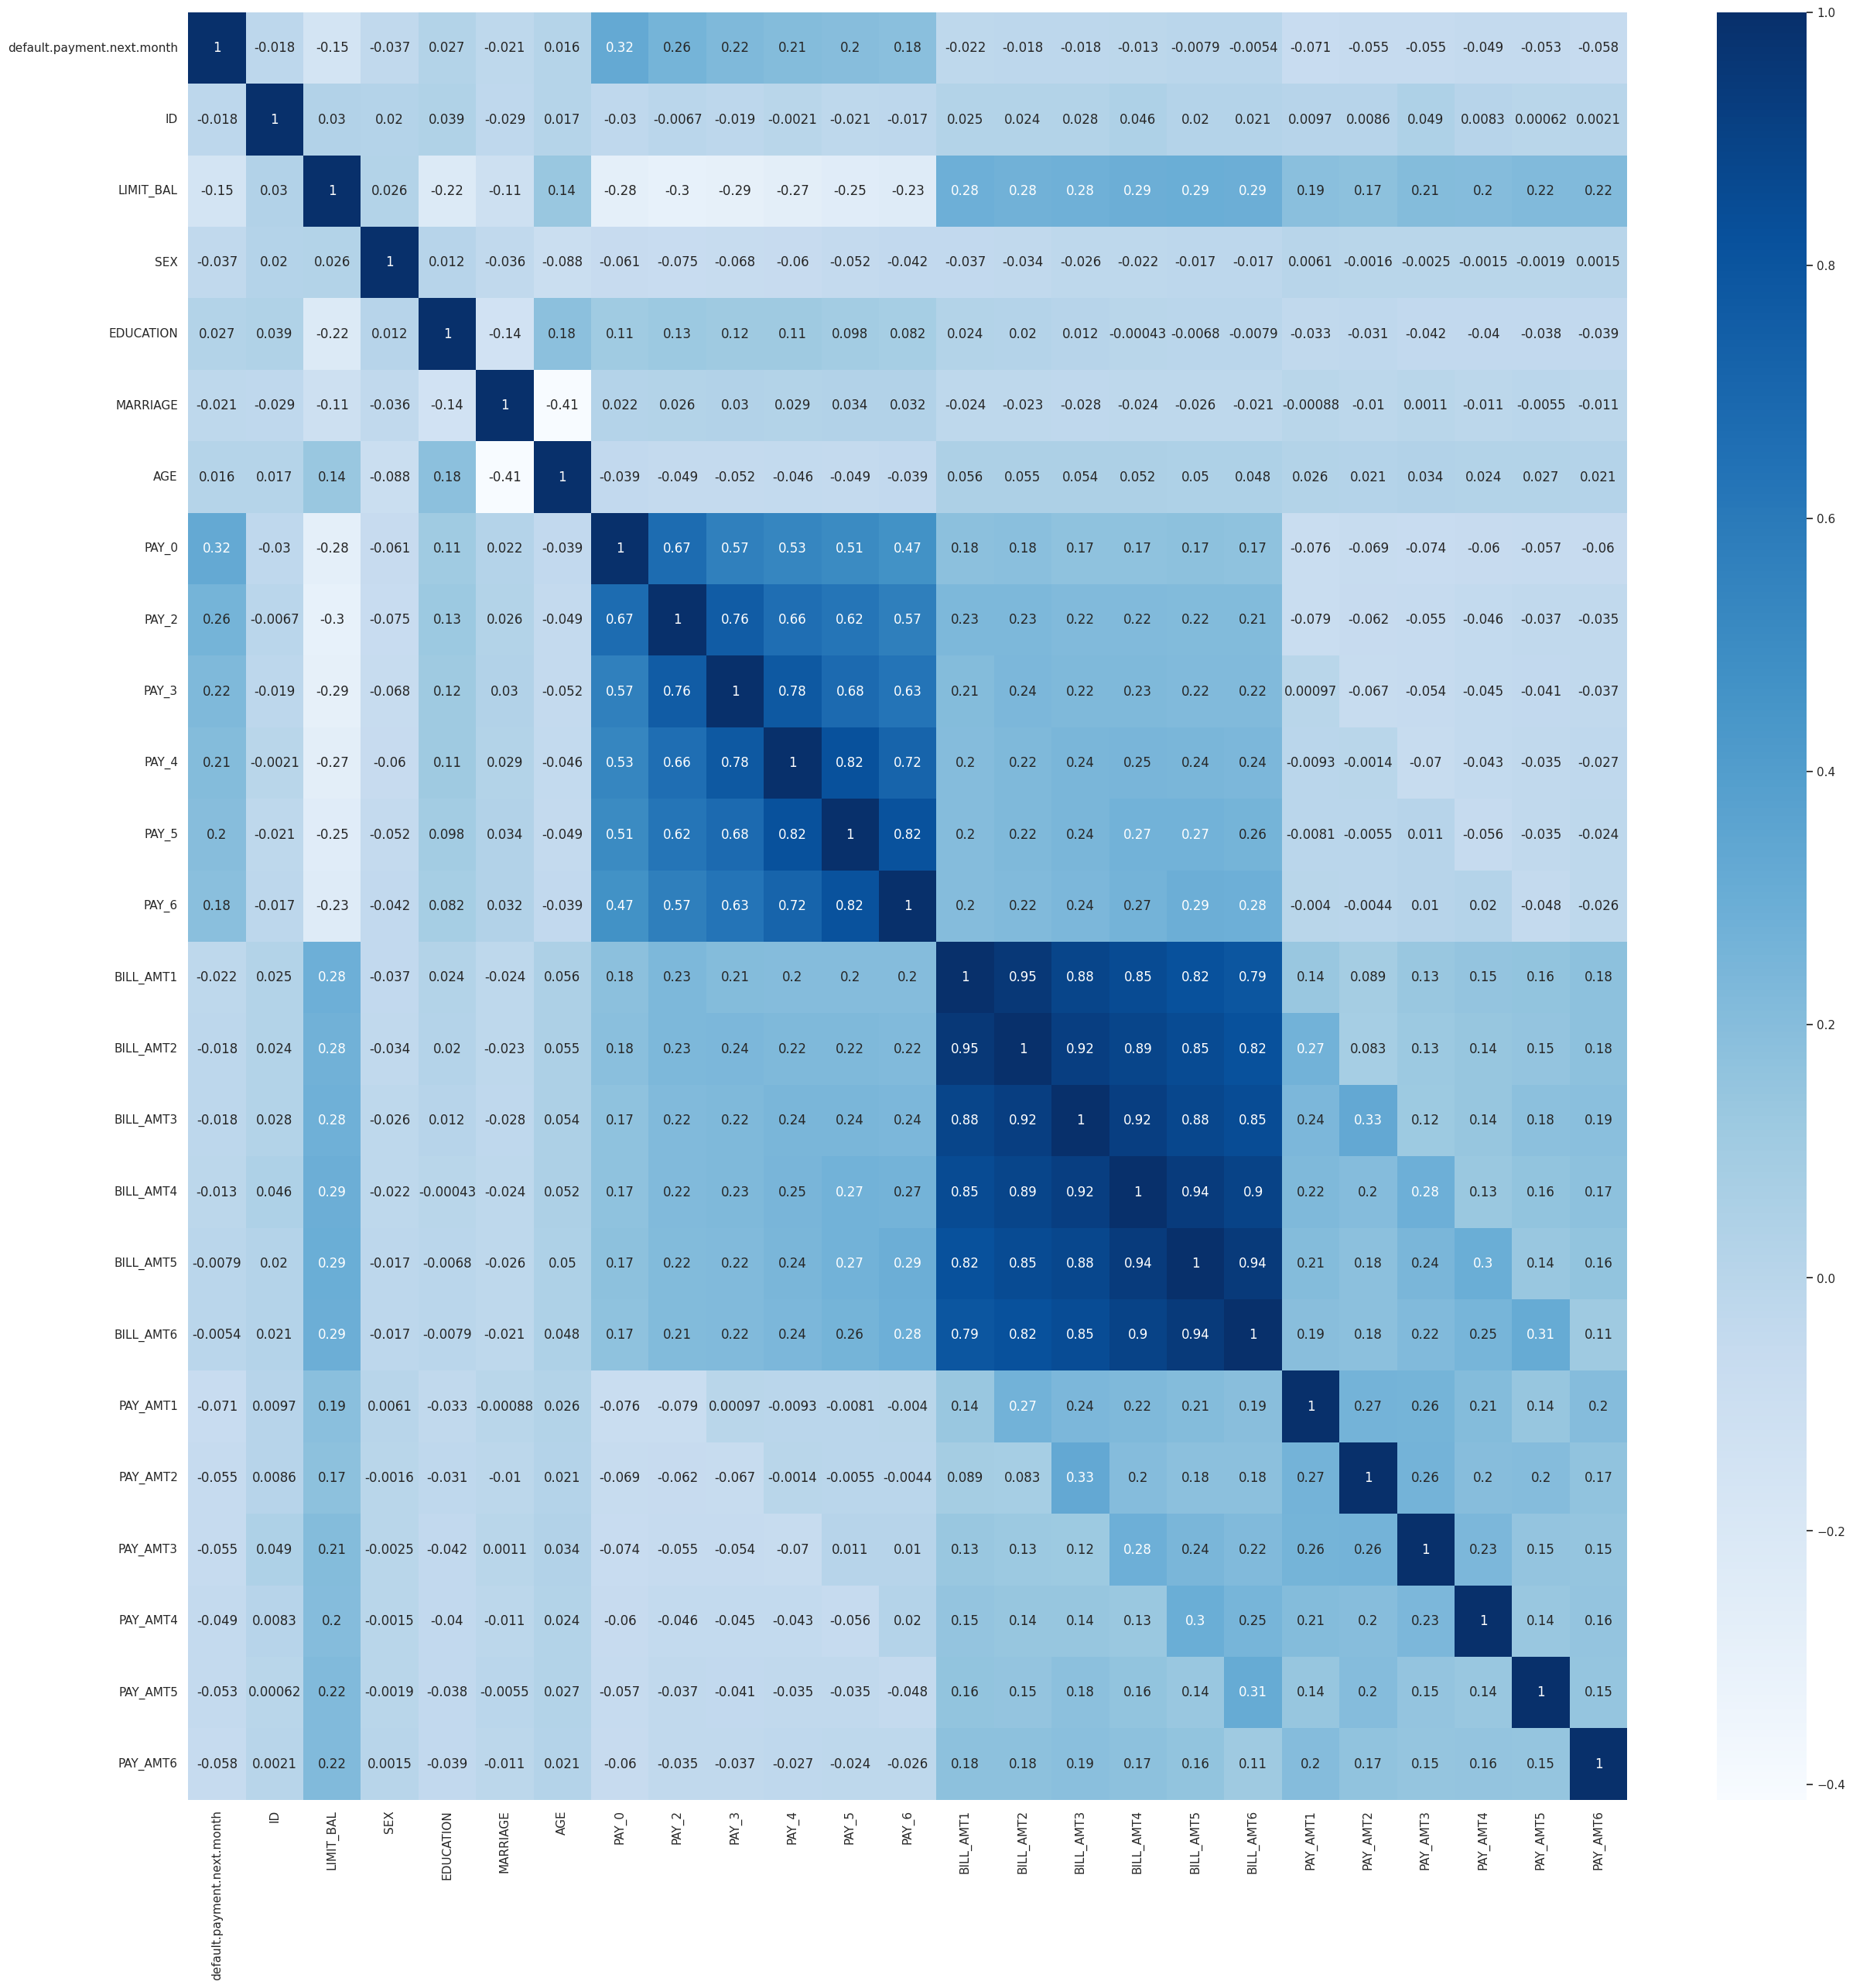

In [ ]:
import seaborn as sns
cor = pd.concat((y_train, X_train), axis=1).iloc[:,:30].corr()
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

I can tell all "PAY_\d" features and "BILL_AMT\d" features are highly correlated.
I can also tell from the scatter plot below.

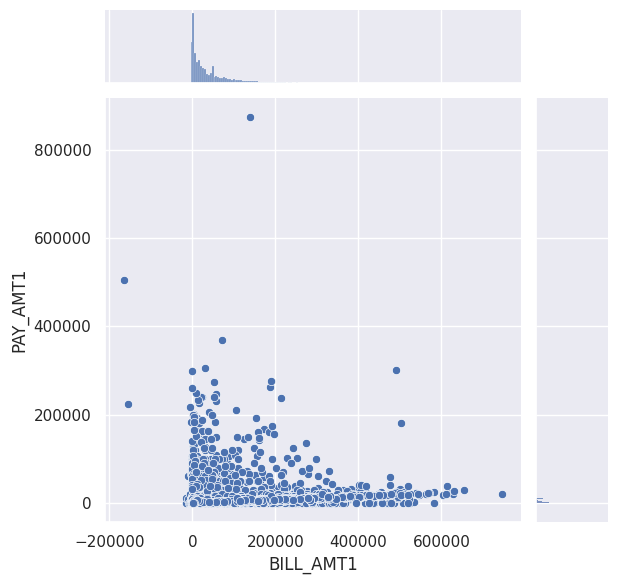

In [ ]:
sns.jointplot(x="BILL_AMT1", y="PAY_AMT1", data=train_df)

Graph below represents the frequency of data points within each bin for the corresponding variable.
Based on these histograms, I can observe there are some outliers for features such as 'EDUCATION', 'MARRIAGE', 'PAY\d' features.

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'LIMIT_BAL'}>,
        <Axes: title={'center': 'SEX'}>,
        <Axes: title={'center': 'EDUCATION'}>,
        <Axes: title={'center': 'MARRIAGE'}>],
       [<Axes: title={'center': 'AGE'}>,
        <Axes: title={'center': 'PAY_0'}>,
        <Axes: title={'center': 'PAY_2'}>,
        <Axes: title={'center': 'PAY_3'}>,
        <Axes: title={'center': 'PAY_4'}>],
       [<Axes: title={'center': 'PAY_5'}>,
        <Axes: title={'center': 'PAY_6'}>,
        <Axes: title={'center': 'BILL_AMT1'}>,
        <Axes: title={'center': 'BILL_AMT2'}>,
        <Axes: title={'center': 'BILL_AMT3'}>],
       [<Axes: title={'center': 'BILL_AMT4'}>,
        <Axes: title={'center': 'BILL_AMT5'}>,
        <Axes: title={'center': 'BILL_AMT6'}>,
        <Axes: title={'center': 'PAY_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT2'}>],
       [<Axes: title={'center': 'PAY_AMT3'}>,
        <Axes: title={'center': 'PAY_AMT4'}>,
        <A

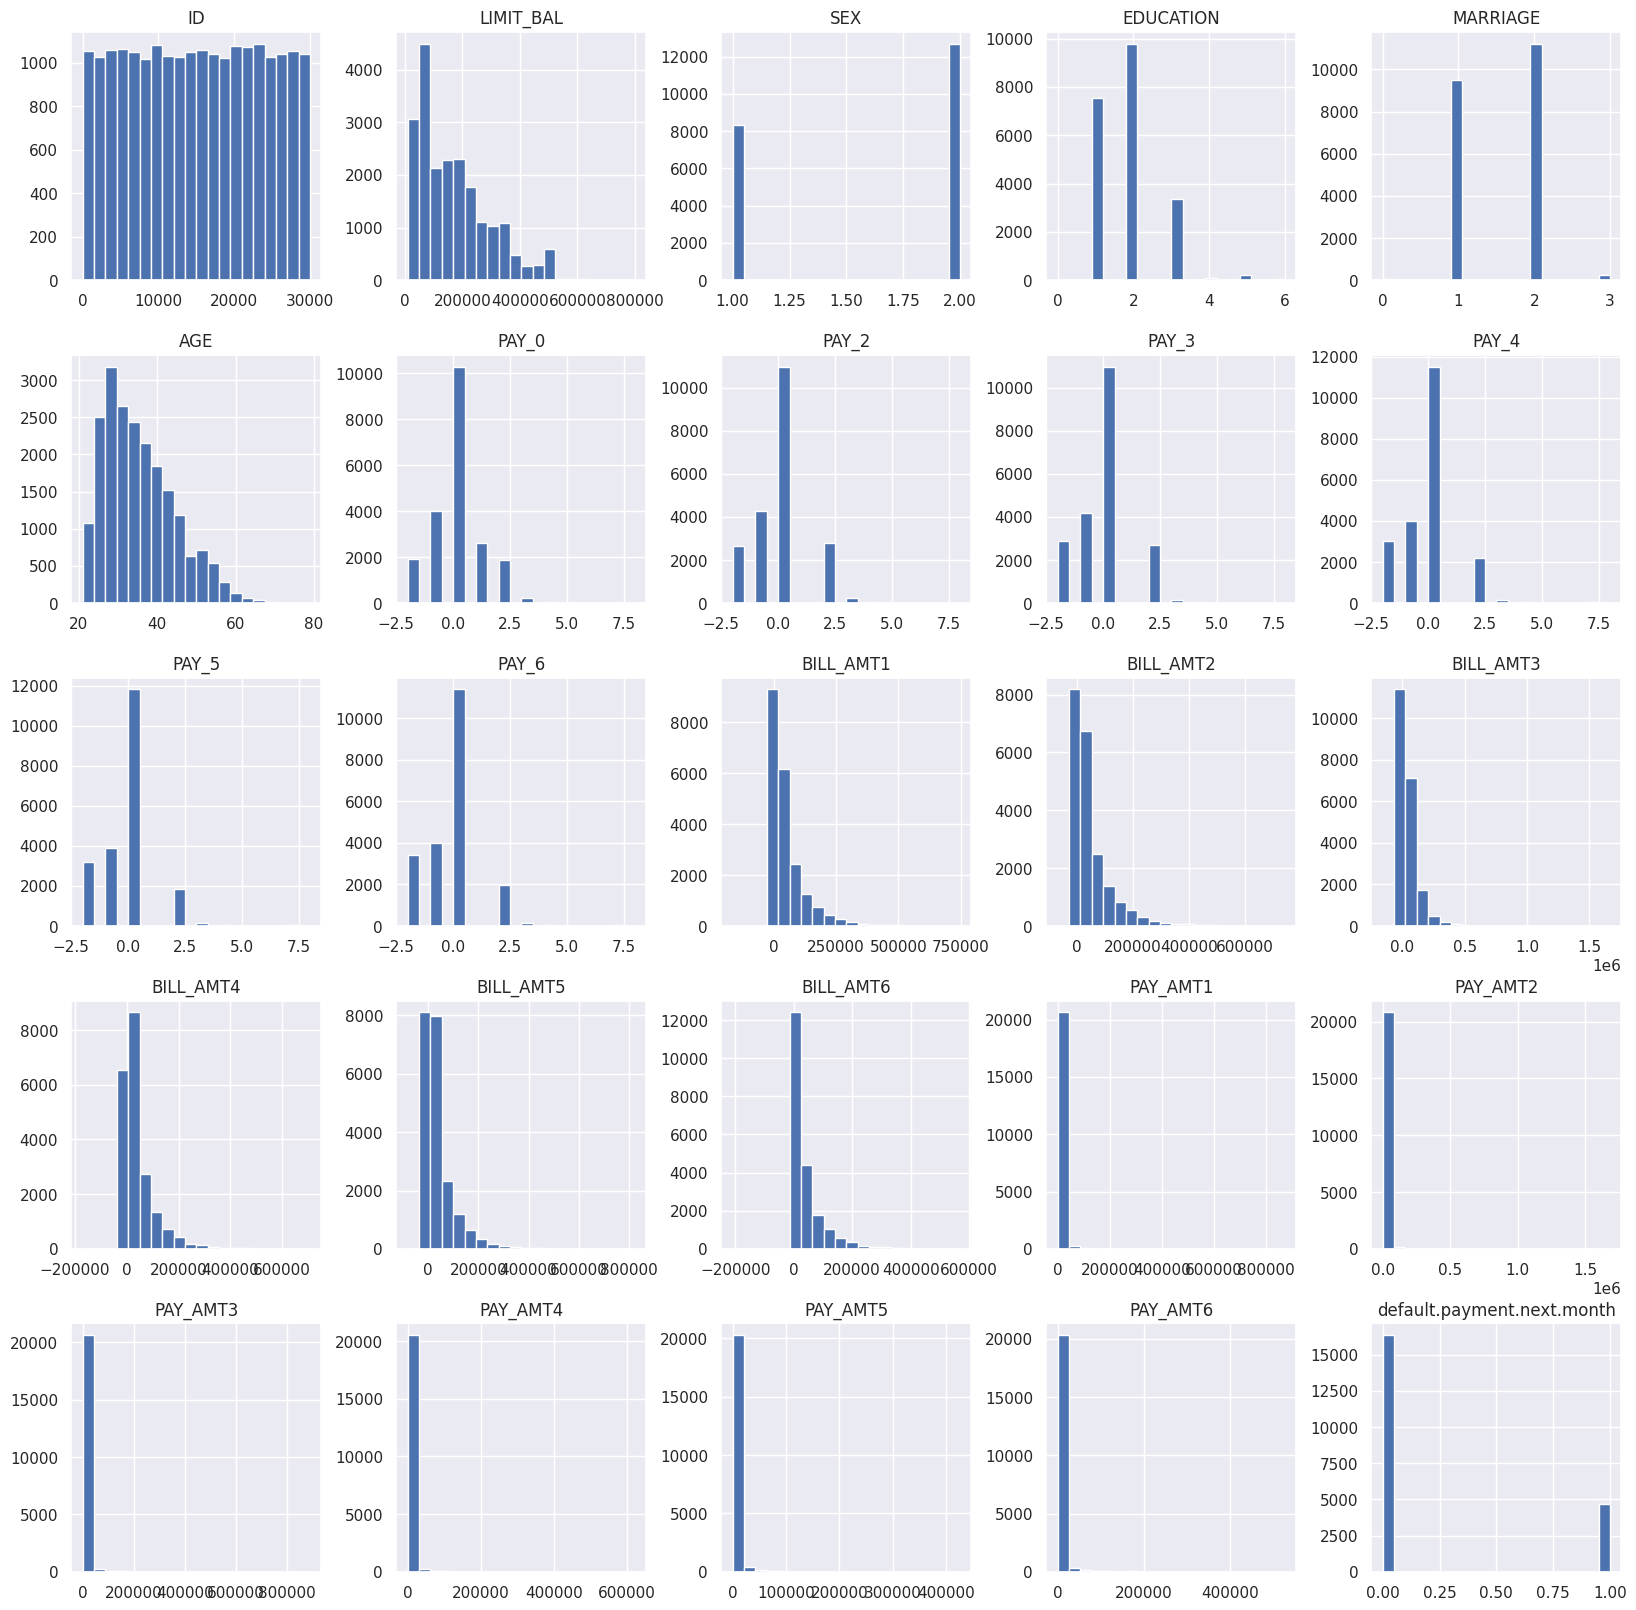

In [ ]:
train_df.hist(figsize=(20,20), bins=20)

So far
- I have very few features.
- I have class imbalance and I need to deal with it. I have chosen macro average f1 as our metric where both classes get equal weight.
- The feature ranges are very difficult, so I will need to standardize.
- I have a number of collinear (highly correlated) features. ("PAY\d" and "BILL_AMT\d")
- I have quite a few outliers features ("EDUCATION", "MARRIAGE", "PAY\d").
- The data is a bit messy.
    - What does it mean by education level 5 and 6?
    - What does it mean for PAY_* to be -2? Or 0?
      - -2: No billing amount for the month.
      - -1: The billing amount was fully paid.
      - 0: No delinquency occurred.
      - 1, 2, 3: Indicates the number of months the payment is overdue.


### Preprocessing and Transformations

- First I will identify numeric and categorical features and use make_column_transformer to apply different transformation on different columns.
- make_column_transformer is similar to make_pipeline syntax but there is some convenient.
    - The syntax automatically names each step based on its class.


In [ ]:
# exclude ID feature
drop_features = ["ID"]
numeric_features = [
    "LIMIT_BAL",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE"
]
binary_features = ["SEX"]
categorical_features = ["EDUCATION", "MARRIAGE"]
target = "default.payment.next.month"

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

Calculate mean and standard deviation of cross validation


Score the model
- Score gives the accuracy of the model
- accuracy = correct predictions / total examples

In [ ]:
from sklearn.dummy import DummyClassifier

results = {}

# Dummy Classifier
dummy = DummyClassifier(strategy="stratified")
dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric)
mean_dummy_scores = pd.DataFrame(dummy_scores).mean()
std_dummy_scores = pd.DataFrame(dummy_scores).std()
out_col = []

for i in range(len(mean_dummy_scores)):
    out_col.append((f"%0.3f (+/- %0.3f)" % (mean_dummy_scores.iloc[i], std_dummy_scores.iloc[i])))

results["dummy"] = pd.Series(data=out_col, index=mean_dummy_scores.index)

# Display Results
results_df = pd.DataFrame(results)
print(results_df)


                         dummy
fit_time     0.004 (+/- 0.001)
score_time   0.005 (+/- 0.001)
test_score   0.500 (+/- 0.008)
train_score  0.500 (+/- 0.004)


In [ ]:
cross_val_score(dummy, X_train, y_train, cv=5)

array([0.65119048, 0.65380952, 0.645     , 0.6497619 , 0.6497619 ])

## Model Training and Evaluation

### Linear Model

- Linear model
- hyperparameter


In [ ]:
# Logregression Classifier
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)

logreg_scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric)
mean_logreg_scores = pd.DataFrame(logreg_scores).mean()
str_logreg_scores = pd.DataFrame(logreg_scores).std()

out_col = []

for i in range(len(mean_logreg_scores)):
    out_col.append((f"%0.3f (+/- %0.3f)" % (mean_logreg_scores.iloc[i], str_logreg_scores.iloc[i])))

results["logreg"] = pd.Series(data=out_col, index=mean_logreg_scores.index)

# Display Results
results_df = pd.DataFrame(results)
print(results_df)

                         dummy             logreg
fit_time     0.004 (+/- 0.001)  0.224 (+/- 0.045)
score_time   0.005 (+/- 0.001)  0.022 (+/- 0.008)
test_score   0.500 (+/- 0.008)  0.626 (+/- 0.004)
train_score  0.500 (+/- 0.004)  0.629 (+/- 0.004)


In [ ]:
from scipy.stats import loguniform

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_A...
                                                                                'MARRIAGE'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b5fd394efb0>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

The result shows that
- The randomized search is evaluating 50 different hyperparameter combinations
- For each combination, 5-fold cross-validation is used to assess its performance.
- This results in a total of 250 model fits

In [ ]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'logisticregression__C': 0.011290431413903906}
Best score: 0.628


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.631350,0.627773,0.011290,0.115702,0.004898
2,0.630839,0.627717,0.023420,0.172873,0.003793
3,0.630789,0.627717,0.022967,0.143412,0.003755
4,0.630798,0.627714,0.031822,0.139308,0.004058
5,0.631466,0.627493,0.012444,0.237402,0.004671
6,0.630699,0.627213,0.004940,0.103112,0.003823
7,0.630112,0.627188,0.057847,0.158969,0.004195
8,0.630299,0.627110,0.052100,0.159418,0.004563
9,0.629620,0.626954,0.114569,0.176546,0.004336


In [ ]:
best_logreg = random_search.best_estimator_

logreg_tuned_scores = cross_validate(best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric)
mean_logreg_tuned_scores = pd.DataFrame(logreg_tuned_scores).mean()
std_logreg_tuned_scores = pd.DataFrame(logreg_tuned_scores).std()
out_col = []

for i in range(len(mean_logreg_tuned_scores)):
    out_col.append((f"%0.3f (+/- %0.3f)" % (mean_logreg_tuned_scores.iloc[i], std_logreg_tuned_scores.iloc[i])))

results["logreg (tuned)"] = pd.Series(data=out_col, index=mean_logreg_tuned_scores.index)

results_df = pd.DataFrame(results)
print(results_df)

                         dummy             logreg     logreg (tuned)
fit_time     0.004 (+/- 0.001)  0.224 (+/- 0.045)  0.132 (+/- 0.024)
score_time   0.005 (+/- 0.001)  0.022 (+/- 0.008)  0.021 (+/- 0.007)
test_score   0.500 (+/- 0.008)  0.626 (+/- 0.004)  0.628 (+/- 0.005)
train_score  0.500 (+/- 0.004)  0.629 (+/- 0.004)  0.631 (+/- 0.004)


Summary
- The logistic regression model performs better than the dummy classifier.
- Tuning the regularization parameter of the logistic regression slightly improved the validation scores from 0.625 to 0.629, but the improvement was small.
- Both models seem to be underfitting since the training and validation scores are very close. Using non-linear models might improve performance.

## Attempt different models (SVC, Random Forest, XGBoost, LightGBM)



### SVC
- Finds the hyperplane that best separates the data points of different classes in the feature space.
    - Hyperplane: a decision surface that separates data points of different classes


### Random Forest - decision trees.
- Combines the predictions of multiple decision trees to produce a more accurate and robust model.
- Advantage: reduces overfitting by averaging multiple trees and handles non-linear relationships, and feature importance



### XGBoost: base model: decision trees
- Extreme Gradient Boosting
- Builds trees sequentially, where each new tree aims to correct the errors made by the previous trees.
- Advantages: high performance, and strong regularization to control overfitting



### LightGBM: based on decision trees
- Similar to xgboost but with several optimizations for speed and efficiency.
- Advantages: faster training times compared to xgboost, lower memory usage, and high accuracy.


In [ ]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio


3.507405022537025

The majority class is roughly 3.507 times more frequent than the minority class. This indicates a significant class imbalance.

In [ ]:
from sklearn.svm import SVC
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "RBF SVM": SVC(),
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=ratio, random_state=2),
}

# Loop through each model, fit it, and store the results
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    model_scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric)
    mean_scores = pd.DataFrame(model_scores).mean()
    std_scores = pd.DataFrame(model_scores).std()

    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    results[name] = pd.Series(data=out_col, index=mean_scores.index)

###
best_logreg = random_search.best_estimator_

logreg_tuned_scores = cross_validate(best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric)
mean_logreg_tuned_scores = pd.DataFrame(logreg_tuned_scores).mean()
std_logreg_tuned_scores = pd.DataFrame(logreg_tuned_scores).std()
out_col = []
###

# Convert the results dictionary to a DataFrame and transpose it for better readability
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221845 -> initscore=-1.254945
[LightGBM] [Info] Start training from score -1.254945
[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 31
[LightGBM] [Info] [b

- I tried these four models with default hyperpamameters.
- SVC seems to underfit similar to logistic regression; the gap between train and test scores are not large. It takes longer to fit compared to other models.
- LGBM seems to be best performing model among these models. It also seems to be much faster and less overfitting compared to Random Forest and XGBoost.

## Hyperparameter Optimization

Now I am going to look for some optimized hyperparameter for the models.


I am going to try GridSearchCV and RandomizedSearchCV to LightGBM model

GridSearchCV


**RandomizedSearchCV**
- Randomly samples values from the given hyperparameter space to find the optimal combination.
- Faster than GridSearchCV, but does not explore all possible combinations.


In [ ]:
from scipy.stats import randint

param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])


In [ ]:

random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_A...
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5fd3a106a0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5fd3a13340>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [ ]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 79}
Best score: 0.703


,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.814841,0.702521,79,12,3.350073,0.004696
2,0.791901,0.702461,62,11,2.571257,0.002779
3,0.814735,0.702371,67,12,2.920715,0.004218
4,0.768550,0.701786,35,10,1.503953,0.002945
5,0.790128,0.700762,42,11,1.838106,0.003554
6,0.840710,0.700172,68,13,3.178931,0.003731
7,0.837229,0.699833,37,13,1.681311,0.005947
8,0.752394,0.699066,76,9,2.597437,0.003063
9,0.862816,0.698801,40,14,2.038777,0.003735


In [ ]:
best_rf_model = random_search_rf.best_estimator_

# Perform cross-validation for the best random forest model
rf_scores = cross_validate(best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric)

# Calculate mean and standard deviation of the scores
mean_rf_scores = pd.DataFrame(rf_scores).mean()
std_rf_scores = pd.DataFrame(rf_scores).std()

# Format the results with mean and standard deviation
out_col = []
for i in range(len(mean_rf_scores)):
    out_col.append((f"%0.3f (+/- %0.3f)" % (mean_rf_scores.iloc[i], std_rf_scores.iloc[i])))

# Add the results to the 'results' dictionary
results["random forest (tuned)"] = pd.Series(data=out_col, index=mean_rf_scores.index)

# Convert the results to a DataFrame and transpose for better readability
results_df = pd.DataFrame(results).T
print(results_df)


                                 fit_time         score_time  \
dummy                   0.004 (+/- 0.001)  0.005 (+/- 0.001)   
logreg                  0.224 (+/- 0.045)  0.022 (+/- 0.008)   
logreg (tuned)          0.132 (+/- 0.024)  0.021 (+/- 0.007)   
RBF SVM                14.501 (+/- 1.036)  2.320 (+/- 0.777)   
random forest           5.997 (+/- 0.606)  0.106 (+/- 0.013)   
xgboost                 0.569 (+/- 0.052)  0.026 (+/- 0.002)   
lgbm                    0.482 (+/- 0.036)  0.041 (+/- 0.007)   
random forest (tuned)   3.384 (+/- 0.560)  0.059 (+/- 0.006)   

                              test_score        train_score  
dummy                  0.500 (+/- 0.008)  0.500 (+/- 0.004)  
logreg                 0.626 (+/- 0.004)  0.629 (+/- 0.004)  
logreg (tuned)         0.628 (+/- 0.005)  0.631 (+/- 0.004)  
RBF SVM                0.674 (+/- 0.010)  0.687 (+/- 0.002)  
random forest          0.674 (+/- 0.008)  0.999 (+/- 0.000)  
xgboost                0.671 (+/- 0.003)  0.868 (+/

Best Hyperparameter Values with RandomForest:

- n_estimators = 79: Ensemble using 79 trees.
- max_depth = 12: Maximum tree depth set to 12.

Best Score: 0.703

The cross-validation F1 score on the test performance with the optimal hyperparameters is 0.703

LGBM hyperparameter optimization

After using RandomizedSearchCV to find the optimal hyperparameters for RandomForest, the next step is to optimize the hyperparameters for LGBM (LightGBM).

In [ ]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    # "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [ ]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221845 -> initscore=-1.254945
[LightGBM] [Info] Start training from score -1.254945
[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the trai

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_A...
                   n_iter=50, n_jobs=1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.01,
                                                                          0.1],
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5fd3370910>,
                                        'lgbmclassifier__subsample': [0.5, 0.75,
                                                                      1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [ ]:
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__n_estimators': 13, 'lgbmclassifier__subsample': 0.5}
Best score: 0.702


,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.716018,0.701993,13,0.10,0.50,0.164239
2,0.712341,0.701416,11,0.10,1.00,0.230758
2,0.712341,0.701416,11,0.10,0.50,0.159956
4,0.719044,0.700404,17,0.10,1.00,0.235867
5,0.704334,0.695475,94,0.01,0.50,0.548208
6,0.719437,0.694075,22,0.10,1.00,0.205859
7,0.719774,0.692165,24,0.10,1.00,0.213073
8,0.698725,0.691062,86,0.01,0.50,0.508034
9,0.693424,0.688776,80,0.01,0.75,0.737070


In [ ]:
# 새로운 LGBM (tuned)을 테이블에 추가하기
# best_lgbm_model = random_search_lgbm.best_estimator_
# results["lgbm (tuned)"] = mean_std_cross_val_scores(
#     best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
# )
# pd.DataFrame(results).T




best_lgbm_model = random_search_lgbm.best_estimator_
lgbm_scores = cross_validate(best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric)

mean_lgbm_scores = pd.DataFrame(lgbm_scores).mean()
std_lgbm_scores = pd.DataFrame(rf_scores).std()

out_col = []
for i in range (len(mean_lgbm_scores)):
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_lgbm_scores.iloc[i], std_lgbm_scores.iloc[i])))

results["lgbm (tuned)"] = pd.Series(data=out_col, index=mean_lgbm_scores.index)
results_df = pd.DataFrame(results).T
print(results_df)

[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221845 -> initscore=-1.254945
[LightGBM] [Info] Start training from score -1.254945
[LightGBM] [Info] Number of positive: 3727, number of negative: 13073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 31
[LightGBM] [Info] [b

Hyperparameter Optimization helps for both Random Forest and LGBM
Random Forest's Best Score: 0.703
LGBM's Best Score:

Both has similar value but I picked LGBM since
- it seems to be overfitting less
- it's much faster

## Feature Importance Analysis Using SHAP

- Feature importance measures how much each feature (input variable) influences the prediction of a machine learning model.

- First, the SHAP library is used to evaluate feature importance, as the eli5 library cannot be used due to compatibility issues with the latest versions of scikit-learn.

## Feature Importance Overview
1. eli5 (Not Used)
  - The eli5 library visualizes feature importance in machine learning models.
  - The eli5.show_weights function identifies the most important features in models like LightGBM.
  - Key points:
    - In tree-based models (e.g., Random Forest, LightGBM), feature importance is computed based on how frequently and significantly a feature contributes during the training process.
    - It provides global feature importance, indicating which features most influence predictions overall.
    - The output does not explain whether a feature has a positive or negative effect on predictions.
    - It allows for a quick understanding of overall feature importance but lacks local interpretability.
2. SHAP (SHapley Additive exPlanations)
    - SHAP calculates the contribution of each feature to a specific prediction, providing a deeper and fairer interpretation of feature importance.


  - Key Characteristics of SHAP:

    - Absolute SHAP Value: A higher absolute SHAP value indicates that the feature has a greater impact on predictions.
    - Global and Local Interpretability:
      - Global Importance: SHAP identifies the top 10 features influencing predictions on average. In this analysis, PAY_0, LIMIT_BAL, and PAY_AMT2 were found to play critical roles.
      - Local Importance: SHAP can explain how each feature contributes to individual predictions.
  - Advantages of SHAP Over Traditional Feature Importance:

    - Fair Contribution Calculation: SHAP considers all possible feature combinations to fairly evaluate each feature's contribution to predictions.
    - Detailed Explanation: SHAP provides not only feature importance but also the direction of the contribution (+/-), indicating whether a feature positively or negatively influences predictions.
    - Clear Interpretation: It explains specific predictions in detail, which is particularly useful for understanding why a model made a specific decision.

## Summary
While eli5 offers a quick visualization of global feature importance, SHAP provides a more comprehensive and interpretable analysis:

  - Identifies key features influencing predictions, such as PAY_0, LIMIT_BAL, and PAY_AMT2.
  - Explains both global and local feature importance.
  - Shows whether features contribute positively or negatively to predictions, enabling deeper insights into model behavior.
  
### Due to the current eli5 and scikit-learn library version conflict, SHAP is used exclusively for feature importance analysis.



In [ ]:
# import eli5

categorical_OHE = list(
    best_lgbm_model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names_out(categorical_features)
)

feature_names = numeric_features + binary_features + categorical_OHE

# eli5.show_weights(
#     best_lgbm_model.named_steps["lgbmclassifier"],
#     feature_names=feature_names,
# )

In [ ]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
8958,1.327292,0.010867,0.110916,0.140824,0.191463,0.234320,0.249384,0.433921,0.516430,0.390631,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22752,0.249673,0.010867,0.110916,0.140824,-0.666566,-0.647372,-0.618399,2.094514,1.813839,-0.625196,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25882,-0.674001,0.010867,0.110916,0.140824,0.191463,0.234320,0.249384,0.377072,0.441322,0.396381,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12925,-0.674001,0.010867,0.110916,0.140824,0.191463,0.234320,0.249384,0.386305,0.456687,0.491731,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23598,-0.674001,-0.880529,-0.724837,-0.695753,-0.666566,-0.647372,-0.618399,-0.657617,-0.660957,-0.211069,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
lgbm_tuned = LGBMClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

[LightGBM] [Info] Number of positive: 4659, number of negative: 16341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221857 -> initscore=-1.254876
[LightGBM] [Info] Start training from score -1.254876


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [ ]:

"""
In the first method, only the SHAP values for a specific class are considered, which may not fully reflect the overall feature importance of the model.
"""
# values = np.abs(lgbm_shap_values[0]).mean(0)
# pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
#     by="SHAP", ascending=False
# )[:10]

"""
The second method calculates the absolute mean of SHAP values across all data points, which provides a more accurate representation of the overall feature importance for the model.
"""

# Calculate the absolute mean of SHAP values for each feature to determine importance
values = np.abs(lgbm_shap_values).mean(axis=0)

# Sort SHAP values and display the top 10 features
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]



,SHAP
PAY_0,0.369358
LIMIT_BAL,0.114283
PAY_AMT2,0.089711
BILL_AMT1,0.077722
PAY_2,0.063107
PAY_AMT1,0.060361
PAY_AMT4,0.056377
PAY_AMT3,0.054990
BILL_AMT2,0.034453
PAY_3,0.034105


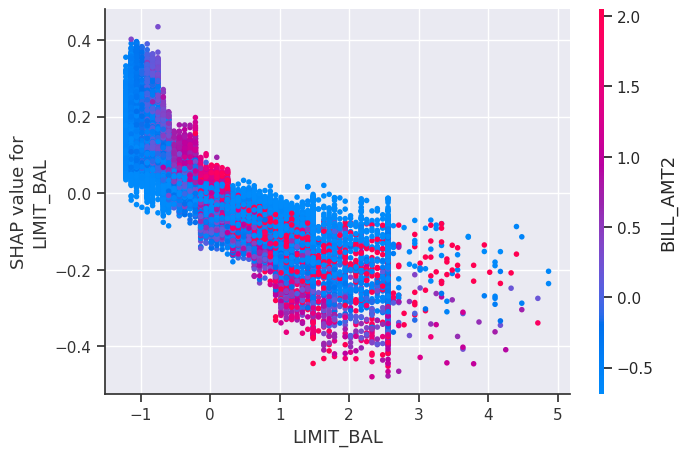

In [ ]:
shap.dependence_plot("LIMIT_BAL", lgbm_shap_values, X_train_enc)



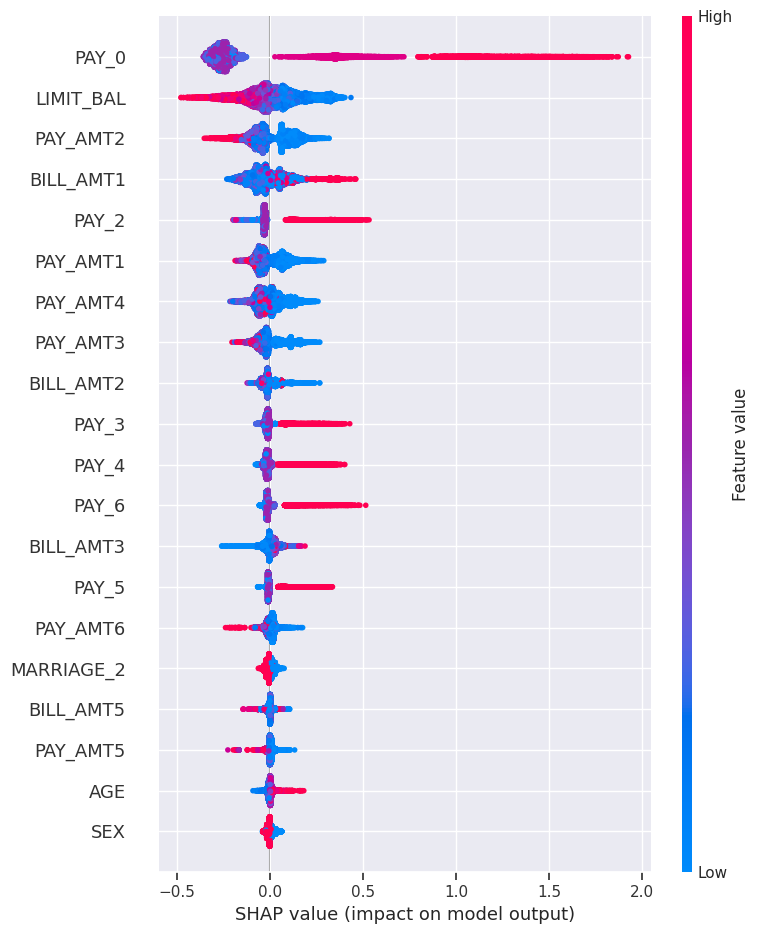

In [ ]:
shap.summary_plot(lgbm_shap_values, X_train_enc)

# SHAP의 절댓값이 클수록 예측 값에 영향을 준
# 기본 값(학습 데이터 세트에 대한 평균 모델 결과값)으로부터 산출된 모델 결과를 최종 모델 결과로 산출하는 것에 대한 변수들의 공헌도

- Ultimately, the higher the value of PAY_#, the greater the absolute SHAP value, indicating a significant impact on the prediction.
- On the other hand, EDUCATION and SEX have little influence on the prediction. This is likely because EDUCATION contains a lot of noise (e.g., unknown values in this column).

In [ ]:
from sklearn.metrics import f1_score

best_model = random_search_lgbm.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_lgbm.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.702
Macro-average f1 score on the test set: 0.702


In [ ]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)

                    precision    recall  f1-score   support

        No default       0.87      0.87      0.87      7023
Default on payment       0.53      0.54      0.54      1977

          accuracy                           0.80      9000
         macro avg       0.70      0.70      0.70      9000
      weighted avg       0.80      0.80      0.80      9000



- The model performs well for the "No default" class, with a high F1-score of 0.87, but shows relatively lower predictive performance for the "Default on payment" class, with an F1-score of 0.54.

- Overall performance metrics are satisfactory, and the macro-average F1-scores for the validation and test sets are similar. This indicates that the model maintains strong generalization performance.

- What is Macro Average?
  - In this binary classification task, the goal is to determine whether a payment default occurs (class 1) or not (class 0).
    - Macro-average Precision: The average of class 0 precision and class 1 precision.
    - Macro-average Recall: The average of class 0 recall and class 1 recall.
    - Macro-average F1-score: The average of class 0 F1-score and class 1 F1-score.
  - Macro-averaging evaluates the model's performance across all classes equally.
  - If the macro F1-scores are similar (within a ~10% difference), it suggests that the model has consistent performance and is likely to generalize well on new data.

## Conclusion

Model Performance:
  - The final machine learning model achieved an overall accuracy of 80%. It demonstrated strong performance for the "No default" class with a precision, recall, and F1-score of 0.87, indicating that the model predicts non-default cases effectively.

Default Prediction Performance:
  - For the "Default on payment" class, the performance was relatively lower, with a precision of 0.53, recall of 0.54, and F1-score of 0.54, highlighting areas for improvement in predicting default cases.

Average Performance Metrics:
  - The macro-average F1-score of 0.70 reflects balanced performance across both classes, with a minor difference between the two F1-scores.
  - The weighted average F1-score of 0.80 further confirms the model's strong overall accuracy and balanced performance.

## Future Improvement Plans
- Remove More Noise and Outliers:
  - Address "unknown" values in EDUCATION and MARRIAGE fields.
  - Handle incorrect data entries, such as age values entered erroneously by customers.

- Feature Engineering:
  - Since BILL_AMT (billing amount) and PAY_AMT (payment amount) are key variables, create a new feature by subtracting these values (e.g., amount_owed), which may yield better predictive results.

- Compare and Analyze New Machine Learning Models:
  - Explore alternative machine learning models to improve the prediction performance for the "Default on payment" class.

